# Gaussian processes: inference

In the previous chapter we have seen how to generate Gaussian process priors. But what we usually would want to do is inference, i.e. given observed data, we would like to estimate model parameters, and, potentially, make predictions at unobserved locations.

## Marginalization and Conditioning

```{margin}
It is helpful to think of $x_n$ and $x_m$ as training and test locations, correspondingly.
```
Assume we have two sets of coordinates $x_n = (x_n^1, x_n^2, ..., x_n^n), x_m = (x_m^1, x_m^2, ..., x_m^m)$ and a GP over them:

$$
\begin{bmatrix} f_n \\ f_m \end{bmatrix} \sim \mathcal{N}\left( \underbrace{\begin{bmatrix} \mu_n \\  \mu_m \end{bmatrix}}_{\mu}, 
\underbrace{\begin{bmatrix}  K_{n n} \quad K_{n m}  \\ K_{m n} \quad K_{m m} \end{bmatrix}}_{K}
\right).
$$

Marginalization allows us to extract partial information from multivariate probability distribution:

$$
\begin{align*}
f_n & \sim \mathcal{N}(\mu_n,  K_{nn}),\\
f_m & \sim \mathcal{N}(\mu_m,  K_{mm}).
\end{align*}
$$

Conditioning allows us to determine the probability of one subset of variables given another subset. Similar to marginalization, this operation is also closed and yields a modified Gaussian distribution:

$$
f_n | f_m \sim \mathcal{N}(\mu_{n|m},  K_{n|m}),
$$

where

$$
\begin{align*}
\mu_{n|m} & = \mu_n + K_{nm} K_{mm}^{-1} (f_m - \mu_m),\\
K_{n|m} & = K_{nn} - K_{nm} K_{mm}^{-1} K_{mn}
\end{align*}
$$

`````{admonition} Group Task 
Write down these formulas for the $d=2$ case, i.e. when both $f_n$ and $f_m$ have only one component each.
`````

Let us visualise such a conditional.

In [18]:
# imports for this chapter
import numpy as np

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro.infer import init_to_median, Predictive, MCMC, NUTS
from numpyro.diagnostics import hpdi

import pickle

numpyro.set_host_device_count(4)  # Set the device count to enable parallel sampling

In [19]:
def Gaussian_conditional(mean, cov, x=None,y=None):
  assert not (x is None and y is None) and not (x is not None and y is not None)
  if x is not None:
    var = cov[1,1] -  cov[1,0] * cov[0,0] ** (-1) * cov[0,1]
    mu = mean[1] + cov[1,0] * cov[0,0] ** (-1) * (x - mean[0])
  else:
    var = cov[0,0] -  cov[0,1] * cov[1,1] ** (-1) * cov[1,0]
    mu = mean[0] + cov[0,1] * cov[1,1] ** (-1) * (y - mean[1])
  return mu, var**0.5

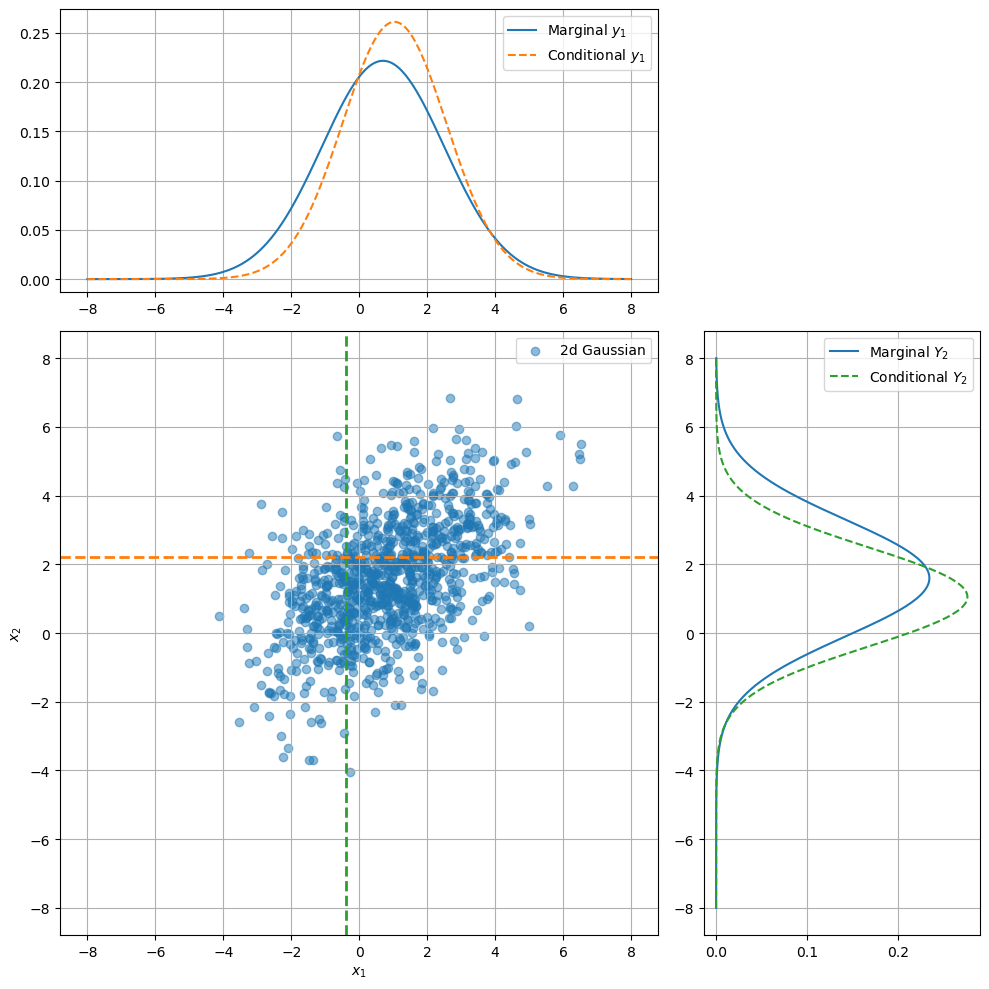

In [20]:
# parameters for the 2D Gaussian distribution
mu1 = 0.7 
mu2 = 1.6 
sigma1 = 1.8 
sigma2 = 1.7 
rho = 0.529 
y1 = -0.4 
y2 = 2.2 

# generate data points from the 2D Gaussian distribution
mu = jnp.array([mu1, mu2])
K = jnp.array([[sigma1**2, rho*sigma1*sigma2],[rho*sigma2*sigma1, sigma2**2]])
num_samples = 1000
data = np.random.multivariate_normal(mu, K, num_samples)

# calculate marginal distributions
y_values = jnp.linspace(-8, 8, 300)

normal1 = dist.Normal(loc=mu1, scale=sigma1)
normal2 = dist.Normal(loc=mu2, scale=sigma2)
density_x1 = jnp.exp(normal1.log_prob(y_values))
density_x2 = jnp.exp(normal2.log_prob(y_values))

# compute conditionals
cond_mu_x1, cond_sigma_x1 = Gaussian_conditional(mu, K, x=None, y=y2)
cond_mu_x2, cond_sigma_x2 = Gaussian_conditional(mu, K, x=y1, y=None)
cond_density_x1 = jnp.exp(dist.Normal(loc=cond_mu_x1, scale=cond_sigma_x1).log_prob(y_values))
cond_density_x2 = jnp.exp(dist.Normal(loc=cond_mu_x2, scale=cond_sigma_x2).log_prob(y_values))


fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(3, 3)

# main plot (2D Gaussian distribution)
ax_main = fig.add_subplot(gs[1:3, :2])
ax_main.scatter(data[:, 0], data[:, 1], alpha=0.5, label='2d Gaussian')
ax_main.set_xlabel('$x_1$')
ax_main.set_ylabel('$x_2$')
ax_main.axvline(y1, lw=2, c='C2', linestyle = '--')
ax_main.axhline(y2, lw=2, c='C1', linestyle = '--')
ax_main.legend()
ax_main.grid(True)

# marginal x1 plot
ax_marginal_x = fig.add_subplot(gs[0, :2], sharex=ax_main)
ax_marginal_x.plot(y_values, density_x1, label='Marginal $y_1$')
ax_marginal_x.plot(y_values, cond_density_x1, label='Conditional $y_1$', linestyle = '--', c='C1')
ax_marginal_x.legend()
ax_marginal_x.grid(True)

# marginal x2 plot
ax_marginal_y = fig.add_subplot(gs[1:3, 2], sharey=ax_main)
ax_marginal_y.plot(density_x2, y_values, label='Marginal $Y_2$' )
ax_marginal_y.plot(cond_density_x2, y_values, label='Conditional $Y_2$', linestyle='--', c='C2')
ax_marginal_y.legend()
ax_marginal_y.grid(True)

plt.tight_layout()
plt.show()

## Inference in GLMMs
In a typical setting, GP enters GLMMs as a latent variable and the model has the form

$$
\begin{align*}
f(x) &\sim \mathcal{GP}(\mu(x), k(x, x')), \\
y | f &\sim \Pi_i p(y_i \vert f(x_i)).
\end{align*}
$$

Here $\{(x_i, y_i)\}_{i=1}^n$ are pairs of observations $y_i$, and locations of those observations $x_i$. The role of $f(x)$ now is to serve as a <font color='orange'>latent field</font> capturing dependencies between locations $x$. The expression $\Pi_i p(y_i \vert f(x_i))$ provides a likelihood, allowing us to link observed data to the model and enabling parameter inference.

```{margin}
The task of predicting at unobserved locations is often referred to as **kriging** and is the underlying concept in spatial statistics. We will talk about it in the next chapter.
```
The task that we usually want to solve is twofold: we want to infer parameters involed in the model, as well as make predictions at unobserved locations $x_*.$

## Gaussian process regression

The simplest case of the setting described above is the Gaussian process regression where the outcome variable is modelled as a GP with added noise $\epsilon$. It assumes that the data consists of pairs $\{(x_i, y_i)\}_{i=1}^n$ and the likelihood is Gaussian with variance $\sigma^2_\epsilon:$

$$
\begin{align*}
f(x) &\sim \mathcal{GP}(\mu(x), k(x, x')),\\
y_i &= f(x_i) + \epsilon_i, \\
\epsilon_i &\sim \mathcal{N}(0, \sigma^2_\epsilon).
\end{align*}
$$

We want to obtain estimates at locations $\{(x_i, y_i)\}_{i=1}^m$. Recall the conditioning formula: if

$$
\begin{align*}
\begin{bmatrix} f_n \\ f_m \end{bmatrix} \sim \mathcal{N}\left(\begin{bmatrix} 0 \\  
0\end{bmatrix}, \\
\begin{bmatrix}  K_{n n} \quad K_{n m}  \\ K_{m n} \quad K_{m m} \end{bmatrix}
\right),
\end{align*}
$$

then 

```{margin}
Notice how `K_{mn} K_{nn}^{-1}` repeatedly participates in computations. It is often convenient to precompute this matrix.
```
$$
\begin{align*}
f_m | f_n &\sim \mathcal{N}(\mu_{m|n},  K_{m|n}),\\
\mu_{m|n} & = K_{mn} K_{nn}^{-1} f_n,\\
K_{m|n} & = K_{mm} - K_{mn} K_{nn}^{-1} K_{nm}.
\end{align*}
$$

There is an issue with this formula since due to the noise we can not observe $f_n$, but we observe $y_n$ instead. The conditional in this case reads as

$$
\begin{align*}
f_m | y_n &\sim \mathcal{N}(\mu_{m|n},  K_{m|n}),\\
\mu_{m|n} & = K_{mn} (K_{nn} + \sigma^2_\epsilon I )^{-1} y_n,\\
K_{m|n} & = K_{mm} - K_{mn} (K_{nn} + \sigma^2_\epsilon I)^{-1} K_{nm}.
\end{align*}
$$

This is the <font color='orange'>predictive distribution</font> of the Gaussian process.

Putting the two distributions side-by-side:

- posterior distribution in the noise-free case

$$
f_m | f_n \sim \mathcal{N}( K_{mn} K_{nn}^{-1} f_n,  K_{mm} - K_{mn} K_{nn} ^{-1} K_{nm})
$$

- posterior distribution in the noisy case

$$
f_m | y_n \sim \mathcal{N}(K_{mn} (K_{nn} + I\sigma^2_\epsilon )^{-1} y_n,  K_{mm} - K_{mn} (K_{nn} + I\sigma^2_\epsilon )^{-1} K_{nm})
$$

Parameters $\theta$ of the model can be learnt using the marginal log-likelihood which for the latter posterior takes the form

$$
\log p(y|\theta)= -\frac{n}{2} \log(2\pi) - \frac{1}{2}\log \vert K_{nn} + \sigma^2_\epsilon I \vert - \frac{1}{2}y^T(K_{nn} + \sigma^2_\epsilon I)^{-1}y
$$

## Computational complexity

Note that the predictive distribution involes inversion of a $n \times n$ matrix. This computation has cubic complexity $O(n^3)$ with respect to the number of points $n$ and creates a computational bottleneck when dealing with GP inference.

Let us implement the predictive distribution.

In [21]:
def rbf_kernel(x1, x2, lengthscale=1.0, sigma=1.0):
    """
    compute the Radial Basis Function (RBF) kernel matrix between two sets of points

    args:
    - x1 (array): array of shape (n1, d) representing the first set of points
    - x2 (array): array of shape (n2, d) representing the second set of points
    - sigma (float): variance parameter
    - length_scale (float): length-scale parameter
    - jitter (float): small positive value added to the diagonal elementsr

    returns:
    - K (array): kernel matrix of shape (n1, n2)
    """
    sq_dist = jnp.sum(x1**2, axis=1).reshape(-1, 1) + jnp.sum(x2**2, axis=1) - 2 * jnp.dot(x1, x2.T)
    K = sigma**2 * jnp.exp(-0.5 / lengthscale**2 * sq_dist)
    return K

In [22]:
def plot_gp(x_obs, y_obs, x_pred, mean, variance, f_true=False):
    """
    plots the Gaussian process predictive distribution

    args:
    - x_obs: training inputs, shape (n_train_samples, n_features)
    - y_train: training targets, shape (n_train_samples,)
    - x_pred: test input points, shape (n_test_samples, n_features)
    - mean: mean of the predictive distribution, shape (n_test_samples,)
    - variance: variance of the predictive distribution, shape (n_test_samples,)
    """
    plt.figure(figsize=(8, 6))
    if not f_true is False:
        plt.plot(x_pred, f_true, label='True Function', color='purple')
    plt.scatter(x_obs, y_obs, c='orangered', label='Training Data')
    plt.plot(x_pred, mean, label='Mean Prediction', color='teal')
    plt.fill_between(x_pred.squeeze(), mean - jnp.sqrt(variance), mean + jnp.sqrt(variance), color='teal', alpha=0.3, label='Uncertainty')
    plt.title('Gaussian Process Predictive Distribution')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    plt.show()

In [23]:
def predict_gaussian_process(x_obs, y_obs, x_pred, length_scale=1.0, sigma=1.0, jitter=1e-8):
    """
    predicts the mean and variance of the Gaussian process at test points

    args:
    - x_obs: training inputs, shape (n_train_samples, n_features)
    - y_obs: training targets, shape (n_train_samples,)
    - x_pred: test input points, shape (n_test_samples, n_features)
    - length_scale: length-scale parameter
    - variance: variance parameter
    - jitter: jitter to ensure computational stability

    returns:
    - mean: Mean of the predictive distribution, shape (n_test_samples,).
    - variance: Variance of the predictive distribution, shape (n_test_samples,).
    """
    K = rbf_kernel(x_obs, x_obs, length_scale, sigma) + jitter * jnp.eye(len(x_obs))
    K_inv = jnp.linalg.inv(K)
    K_star = rbf_kernel(x_obs, x_pred, length_scale, sigma)
    K_star_star = rbf_kernel(x_pred, x_pred, length_scale, sigma)

    mean = jnp.dot(K_star.T, jnp.dot(K_inv, y_obs))
    variance = jnp.diag(K_star_star) - jnp.sum(jnp.dot(K_star.T, K_inv) * K_star.T, axis=1)

    return mean, variance

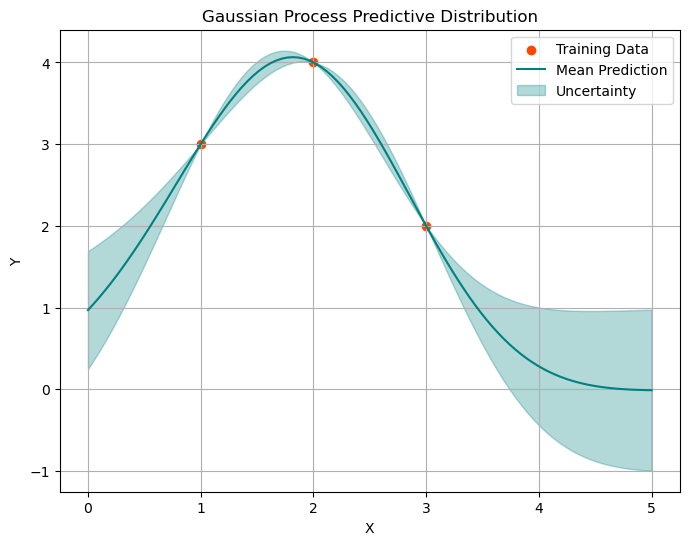

In [24]:
# example 
x_obs = jnp.array([[1], [2], [3]])               # training inputs
y_obs = jnp.array([3, 4, 2])                     # training targets
x_pred = jnp.linspace(0, 5, 100).reshape(-1, 1)  # test inputs

mean, variance = predict_gaussian_process(x_obs, y_obs, x_pred)
plot_gp(x_obs, y_obs, x_pred, mean, variance)

This seem to work well. Let's take a look at some noisy data.

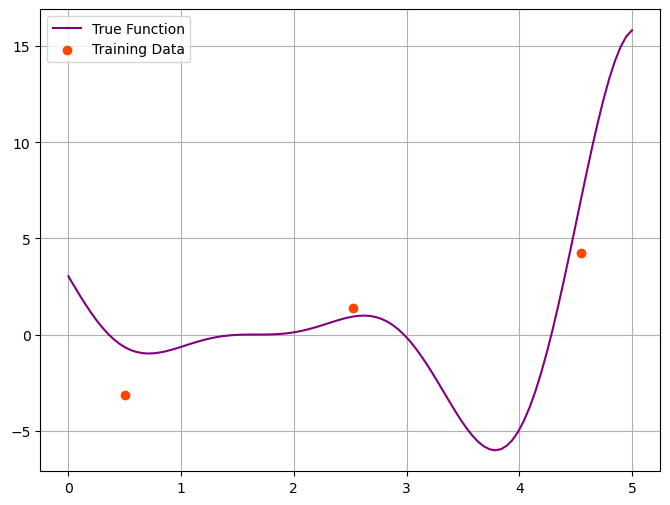

In [25]:
#  the true pattern
def f(x):
    return (6 * x/5 - 2)**2 * jnp.sin(12 * x/5 - 4)

# generate true function values
x = jnp.linspace(0, 5, 100)
f_true = f(x)

# sample noise with a normal distribution
noise = 2*jax.random.normal(jax.random.PRNGKey(0), shape=f_true.shape)

# add noise to the true function values to obtain the observed values (y)
y = f_true + noise

# indices of observed data points
idx_obs = jnp.array([[10], [50], [90]])
x_obs = x[idx_obs]
y_obs = y[idx_obs].reshape(-1)

plt.figure(figsize=(8, 6))
plt.plot(x, f_true, label='True Function', color='purple')
plt.scatter(x_obs, y_obs, color='orangered', label='Training Data')
plt.grid()
plt.legend()


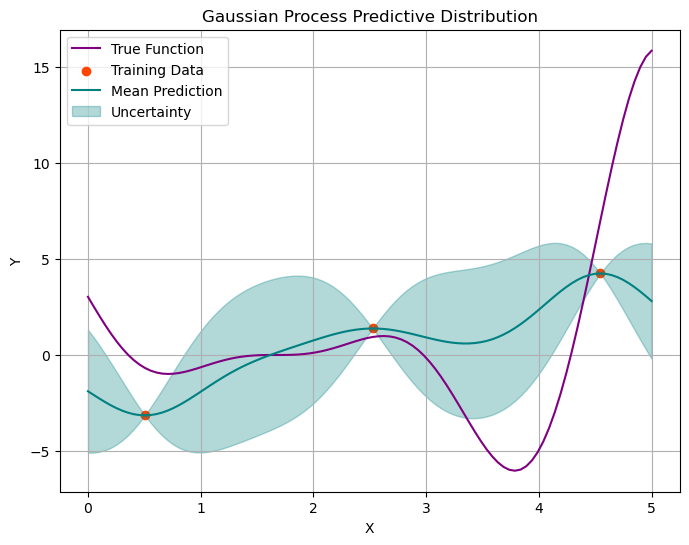

In [26]:
mean, variance = predict_gaussian_process(x_obs, y_obs, x_pred, length_scale=0.5, sigma=4)
plot_gp(x_obs, y_obs, x_pred, mean, variance, f_true)


Let's add more points and repeat the procedure.


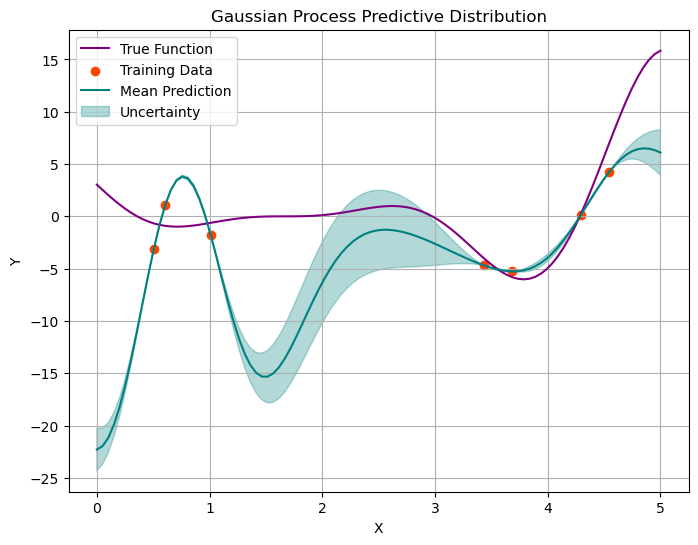

In [27]:
# indices of observed data points
idx_obs = jnp.array([[10], [12],[20], [68], [73], [85], [90]])
x_obs = x[idx_obs]
y_obs = y[idx_obs].reshape(-1)

mean, variance = predict_gaussian_process(x_obs, y_obs, x_pred, length_scale=0.5, sigma=4)
plot_gp(x_obs, y_obs, x_pred, mean, variance, f_true)

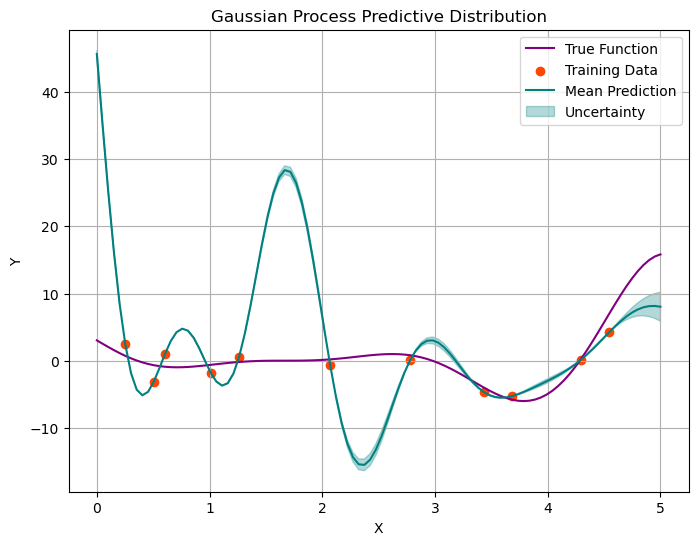

In [28]:
# Indices of observed data points
idx_obs = jnp.array([[5], [10], [12],[20], [25], [41], [55],[68], [73], [85], [90]])
x_obs = x[idx_obs]
y_obs = y[idx_obs].reshape(-1)

mean, variance = predict_gaussian_process(x_obs, y_obs, x_pred, length_scale=0.5, sigma=4)
plot_gp(x_obs, y_obs, x_pred, mean, variance, f_true)

As the number of observed data points increases, we observe two phenomena. Fisrtly, the unertainty bounds are shrinking (as expected); however, rather that trying to generalise, our models starts passing through every point.

## Non-Gaussian likelihoods

We have seen that in the Normal-Normal setting, posterior distribution was accessible analytically.

For non-conjugate likelihood models this is not the case. When the likelihood is non-Gaussian, the resulting posterior distribution is no longer Gaussian, and obtaining a closed-form expression for the predictive distribution may be challenging or impossible. 

In such cases, computational methods such as Markov Chain Monte Carlo or Variational Inference are often used to approximate the predictive distribution. We will use Numpyro and its MCMC engine for this purpose.

## Draw GP priors using Numpyro functionality

In the previous chapter we saw how to draw GP priors numerically. While we don't necessarily *need* Numpyro to do inference in the case of Gaussian likelihood, we will soon see that we will *need* Numpyro for inference in other cases. 

Let us start building that code by drawing GP priors using Numpyro functionality.

In [29]:
def plot_gp_samples(x, samples, ttl="", num_samples=10):
    
    plt.figure(figsize=(6, 4))
    for i in range(num_samples):
        plt.plot(x, samples[i], label=f'Sample {i}')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(ttl)
    plt.legend()
    plt.tight_layout()
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()

In [30]:
def model(x, y=None, kernel_func=rbf_kernel, lengthcsale=0.2, jitter=1e-5, noise=0.5):    
    """
    Gaussian Process prior with a Numpyro model

    args:
    - x (jax.numpy.ndarray): input data points of shape (n, d), where n is the number of points and d is the number of dimensions
    - kernel_func (function): kernel function to use
    - lengthscale (float): length-scale parameter
    - jitter (float): jitter for numerical stability

    returns:
    - numpyro.sample: a sample from the Multivariate Normal distribution representing the noisy function values at input points
    """

    n = x.shape[0]

    K = kernel_func(x, x, lengthcsale) + jitter*jnp.eye(n)

    f = numpyro.sample("f", dist.MultivariateNormal(jnp.zeros(n), covariance_matrix=K))
    
    numpyro.sample("y", dist.Normal(f, noise), obs=y)

/var/folders/qz/bp268sl946v4c1f68pd681n40000gp/T/ipykernel_52259/2836025616.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x, mean, 'b-', label='Mean', color='teal')  # point-wise mean of all samples


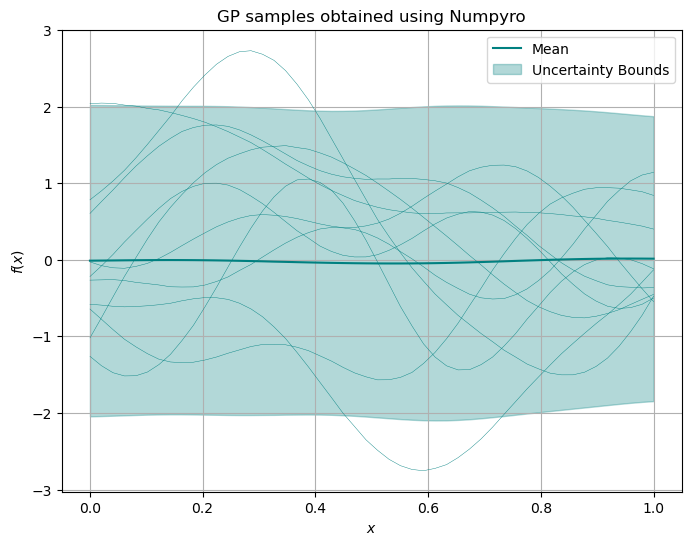

In [31]:
n_points = 50
num_samples = 1000

# input locations
x = jnp.linspace(0, 1, n_points).reshape(-1, 1)

mcmc_predictive = Predictive(model, num_samples=num_samples)
samples = mcmc_predictive(jax.random.PRNGKey(0), x=x)
f_samples = samples['f']

# calculate mean and standard deviation
mean = jnp.mean(f_samples, axis=0)
std = jnp.std(f_samples, axis=0)


plt.figure(figsize=(8, 6))
for i in range(10):
    plt.plot(x, f_samples[i], color='teal', lw=0.3)
plt.plot(x, mean, 'b-', label='Mean', color='teal')  # point-wise mean of all samples
plt.fill_between(x.squeeze(), mean - 1.96 * std, mean + 1.96 * std, color='teal', alpha=0.3, label='Uncertainty Bounds')  # uncertainty bounds
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title('GP samples obtained using Numpyro')    
plt.grid()
plt.legend()
plt.show()

## Inference with Numpyro: known noise

For inference, we will use the simulated data in the previous step as input.

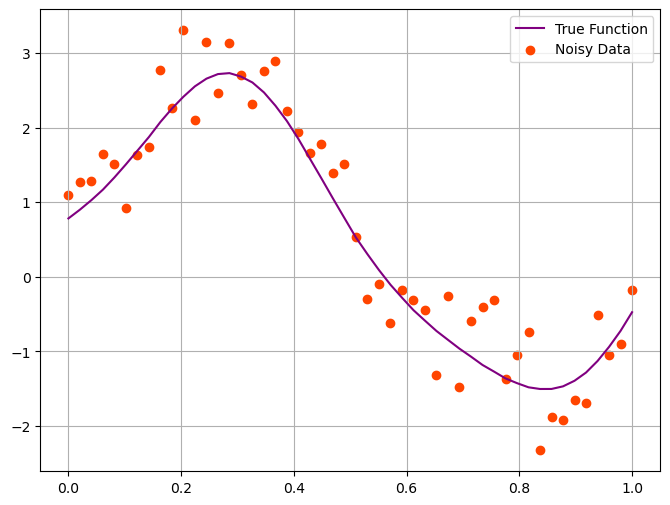

In [32]:
true_idx = 3

y_samples = samples['y']
f_true = f_samples[true_idx]
y_obs =  y_samples[true_idx]

plt.figure(figsize=(8, 6))
plt.plot(x, f_true, label='True Function', color='purple')
plt.scatter(x, y_obs, color='orangered', label='Noisy Data')
plt.grid()
plt.legend()



Let us see whether we can recover $f$ from observed $y$ values. At this stage we assume that the amount of noise is known.

```{margin}
Note the new parameter `progress_bar=False` in the `MCMC` call in the next cell. It suppresses the progress bar, which can speed up model execusion. The drawback is, of course, that if a model takes long to execute, we will not know how many iterations have been already performed.
```

In [33]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10000, num_warmup=2000, num_chains=2, chain_method='parallel', progress_bar=False)
mcmc.run(jax.random.PRNGKey(42), x, y_obs)

In [34]:
# print summary statistics of posterior
mcmc.print_summary()

# get the posterior samples
posterior_samples = mcmc.get_samples()
f_posterior = posterior_samples['f']


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]      0.97      0.26      0.98      0.55      1.41   2563.09      1.00
      f[1]      1.10      0.22      1.09      0.72      1.46   2363.10      1.00
      f[2]      1.23      0.19      1.23      0.91      1.55   2253.81      1.00
      f[3]      1.38      0.18      1.38      1.10      1.68   2205.12      1.00
      f[4]      1.54      0.17      1.54      1.27      1.82   2168.36      1.00
      f[5]      1.70      0.16      1.70      1.45      1.98   2134.11      1.00
      f[6]      1.87      0.16      1.87      1.62      2.15   2102.07      1.00
      f[7]      2.05      0.16      2.04      1.79      2.31   2046.01      1.00
      f[8]      2.21      0.16      2.21      1.95      2.47   1962.15      1.00
      f[9]      2.37      0.16      2.36      2.12      2.65   1856.87      1.00
     f[10]      2.50      0.16      2.50      2.24      2.75   1714.64      1.00
     f[11]      2.62      0

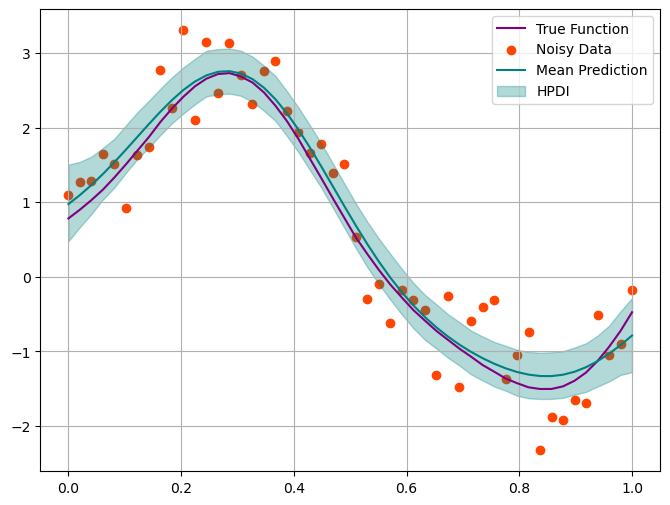

In [35]:
# calculate mean and standard deviation
f_mean = jnp.mean(f_posterior, axis=0)
f_hpdi = hpdi(f_posterior, 0.95)

plt.figure(figsize=(8, 6))
plt.plot(x, f_true, label='True Function', color='purple')
plt.scatter(x, y_obs, color='orangered', label='Noisy Data')
plt.plot(x, f_mean, color='teal', label='Mean Prediction')
plt.fill_between(x.squeeze(), f_hpdi[0], f_hpdi[1], color='teal', alpha=0.3, label='HPDI')  # uncertainty bounds
plt.grid()
plt.legend()
plt.show()

This looks good. But in reality we barely ever know true level of noise.

## Inference with Numpyro: estimating noise

In [36]:
def model(x, y=None, kernel_func=rbf_kernel, lengthcsale=0.2, jitter=1e-5):    
    """
    args:
    - x (jax.numpy.ndarray): input data points of shape (n, d), where n is the number of points and d is the number of dimensions
    - kernel_func (function): kernel function 
    - lengthscale (float): length-scale parameter 
    - jitter (float): jitter for numerical stability

    returns:
    - numpyro.sample: a sample from the Multivariate Normal distribution representing the function values at input points
    """

    n = x.shape[0]

    K = kernel_func(x, x, lengthcsale) + jitter*jnp.eye(n)

    f = numpyro.sample("f", dist.MultivariateNormal(jnp.zeros(n), covariance_matrix=K))

    sigma = numpyro.sample("sigma", dist.HalfCauchy(1))
    
    numpyro.sample("y", dist.Normal(f, sigma), obs=y)

In [37]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10000, num_warmup=2000, num_chains=2, chain_method='parallel', progress_bar=False)
mcmc.run(jax.random.PRNGKey(42), x, y_obs)

In [38]:
# Print summary statistics of posterior
mcmc.print_summary()

# Get the posterior samples
posterior_samples = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]      0.98      0.25      0.98      0.56      1.39   2637.50      1.00
      f[1]      1.10      0.22      1.09      0.74      1.44   2492.22      1.00
      f[2]      1.23      0.19      1.23      0.92      1.54   2386.22      1.00
      f[3]      1.38      0.17      1.38      1.07      1.64   2314.25      1.00
      f[4]      1.54      0.16      1.54      1.28      1.81   2250.23      1.00
      f[5]      1.70      0.16      1.70      1.45      1.97   2168.63      1.00
      f[6]      1.88      0.16      1.88      1.62      2.14   2074.52      1.00
      f[7]      2.05      0.16      2.05      1.77      2.30   1974.76      1.00
      f[8]      2.22      0.16      2.22      1.96      2.49   1875.69      1.00
      f[9]      2.38      0.16      2.38      2.12      2.64   1792.96      1.00
     f[10]      2.52      0.16      2.52      2.25      2.77   1728.06      1.00
     f[11]      2.63      0

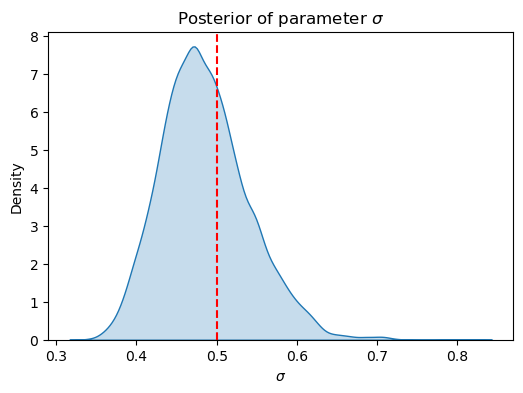

In [39]:
sigma_posterior = posterior_samples['sigma']

plt.figure(figsize=(6, 4))
sns.kdeplot(sigma_posterior, fill=True)
plt.axvline(x=0.5, color='r', linestyle='--', label='True value')
plt.xlabel('$\sigma$')
plt.ylabel('Density')
plt.title('Posterior of parameter $\sigma$')

# Show the plot
plt.show()

We have inferred the variance parameter successfully. Estimating lengthscale, especially for less smooth kernels is harder. One more issue is the non-identifiability of the pair lengthscale-variance. Hence, if they both really *need* to be inferred, strong priors would be beneficial.